In [11]:
from __future__ import division
import argparse
import pandas as pd

# useful stuff
import numpy as np
from scipy.special import expit
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import os
import io
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re
import json
import umap
import random

folder_out = "/home/louis/Documents/Data_science/YJ_PROJECT/Data/NLP_DATA/"
folder_in = "/home/louis/Documents/Data_science/YJ_PROJECT/Data/Data/"

# Deep walk on answers from Le grand débat

## Data Cleaning

In [12]:
def loadStopwords(path):
    #import stopwords file
    stopwords_file = open(path, 'r')
    stopwords = []
    for word in stopwords_file:
        stopwords.append(word.strip('\n'))

    return stopwords

In [13]:
def clean_sentence(sentence, stopwords):
    #sentence = re.findall(r"[\W+']+", sentence.lower())
    sentence=re.split('\W+',sentence.lower())
    rx=re.compile('\W+')
    sentence = [rx.sub(' ',i).strip() for i in sentence if i not in stopwords and rx.sub(' ',i).strip()!= '']
    new_sentence=[]
    for token in sentence:
        if (token[-2:]=="ée") | (token[-2:]=="és") | (token[-2:]=="es") | (token[-2:]=="ns")| (token[-2:]=="rs") | (token[-2:]=="ts") | (token[-2:]=="fs"):
            new_sentence.append(token[:-1])
        else:
            new_sentence.append(token)
        
    return new_sentence

In [14]:

def tokenize_response(theme,num_response,stopwords):
    with open(folder_in+theme+".json") as json_file:
        json_data = json.load(json_file) 

    l=len(json_data) 
    sentences = []
    for i in range(l):
        resp=json_data[i]['responses'][num_response]['value']
        if resp!=None:
            sentences.append(clean_sentence(resp, stopwords))
    json_file.close()

    return sentences

In [15]:
def create_edge_list(tokenize_sentences,theme, num_response,window_size): 
    word_2_num={}
    i=0
    for sentence in tokenize_sentences:
        for token in sentence:
            if token not in word_2_num.keys():
                i+=1
                word_2_num[token]=str(i)

    name_file = theme+"_"+str(num_response)+".edgelist"
    edge_list = open(folder_out+name_file, "w+")
    for sentence in tokenize_sentences:
        if sentence:
            for i,token in enumerate(sentence):
                for neighbor in sentence[min(0,i-window_size):max(i+window_size,len(sentence))]:
                    if token!=neighbor:
                        line=word_2_num[token]+" "+word_2_num[neighbor]
                        edge_list.write(line)
                        edge_list.write('\n')
    edge_list.close()
    num_2_word = {v:k for k,v in word_2_num.items()}
    return word_2_num, num_2_word

In [16]:
# load stopword
path_stopwords = folder_out+'stopwords.txt'
stopwords = loadStopwords(path_stopwords)
# create tokens
tokenize_sentences=tokenize_response("LA_TRANSITION_ECOLOGIQUE",1,stopwords)
# create edge list file = ---.edgelist
word_2_num, num_2_word = create_edge_list(tokenize_sentences,"LA_TRANSITION_ECOLOGIQUE",1,10)

## Analysis of embedding

In [162]:
#load deepwalk output from https://github.com/phanein/deepwalk
node=[]
data_emb=[]
with io.open(os.path.join(folder_out, "fiscalite.embeddings"), encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i>0:
        
            node_, vec = line.rstrip().split(' ', 1)

            data_emb.append(np.fromstring(vec, sep=' ').tolist())
            node.append(node_)
       

In [ ]:
### PCA on follower network

%matplotlib inline
plt.figure(figsize=(10,10))
pca= PCA(n_components=2, random_state=0)
Y = pca.fit_transform(data_emb)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords,s=0.005)
#plt.show()

In [115]:

embedding = umap.UMAP(n_neighbors=10,min_dist=0.05,metric='correlation',n_components=3).fit_transform(data_emb)

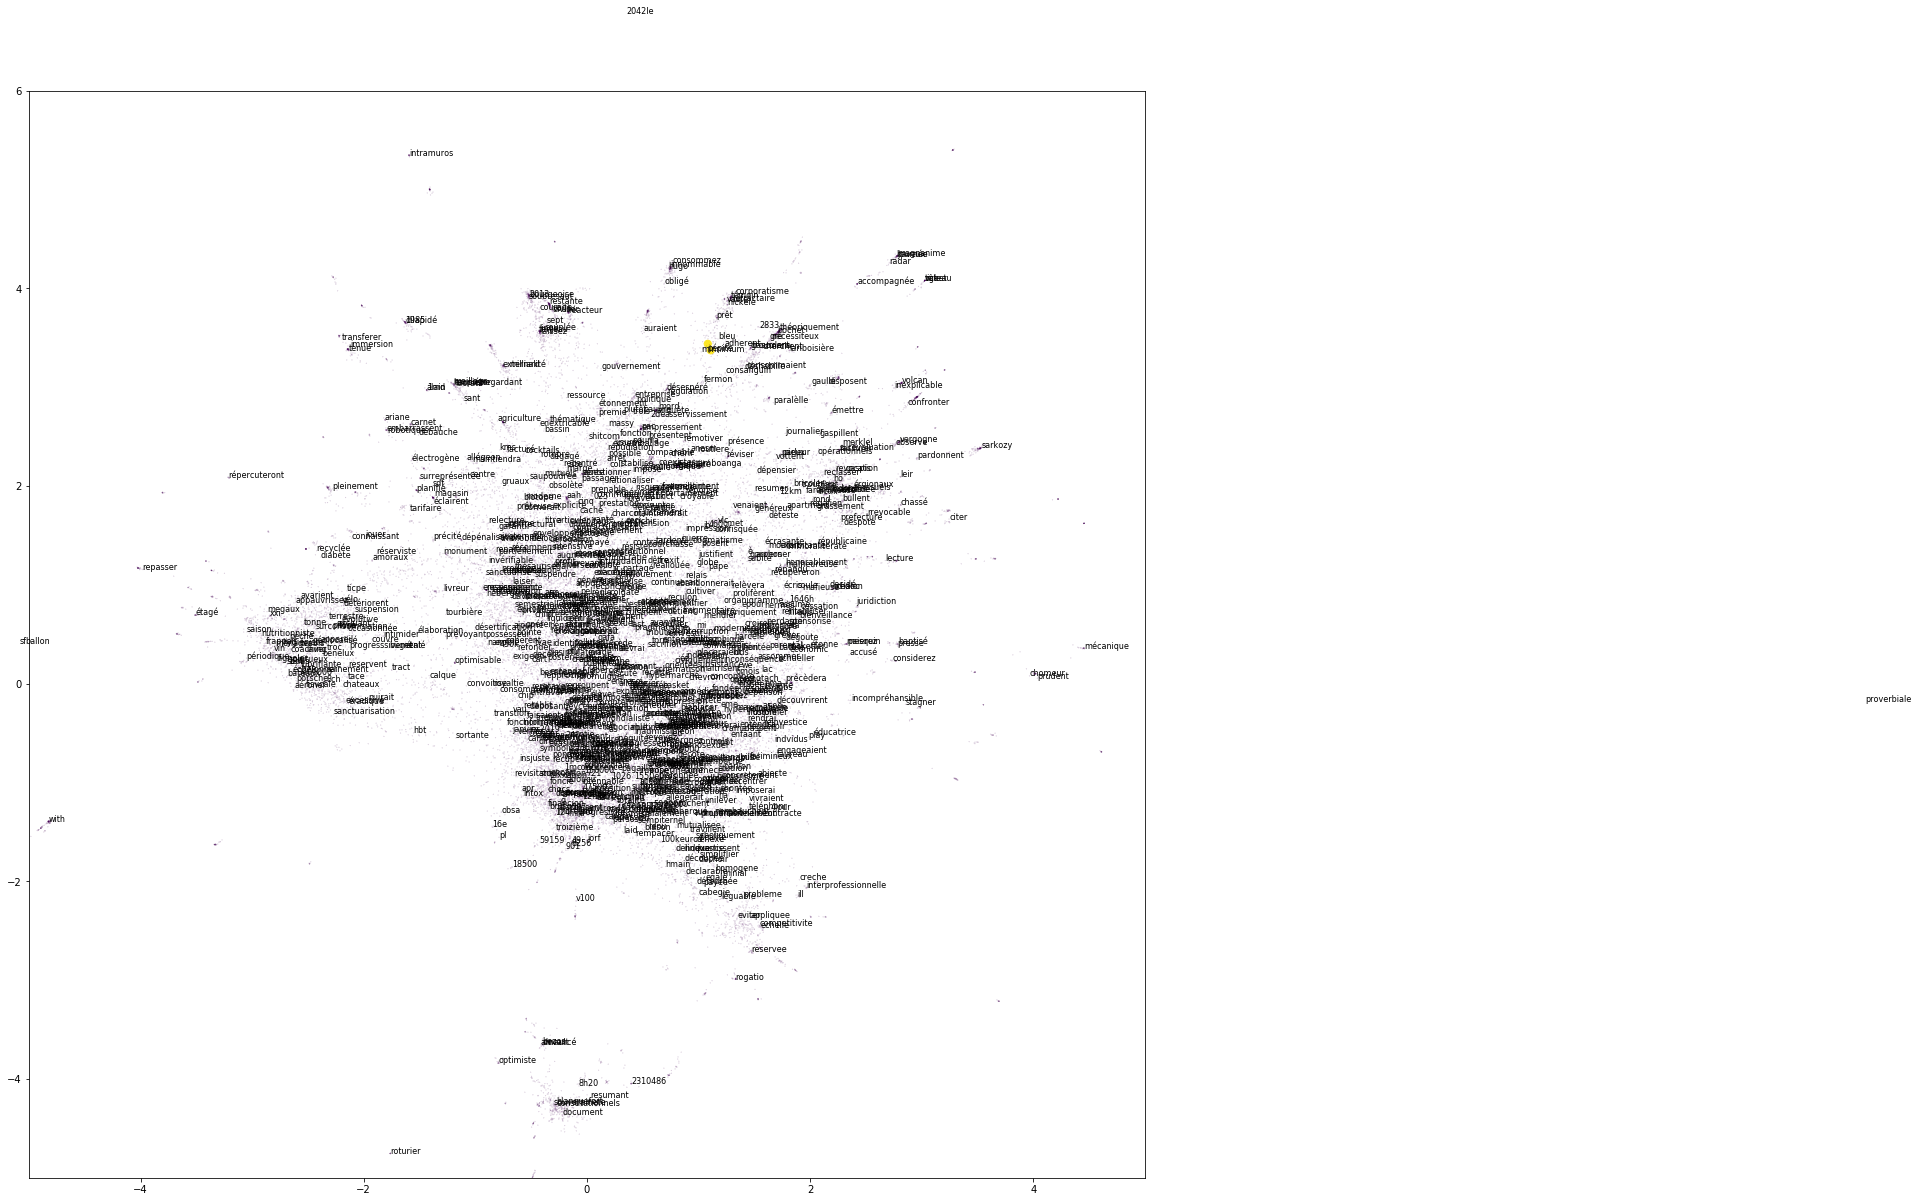

In [161]:
plt.figure(figsize=(20,20))
x_coords = embedding[:, 0]
y_coords = embedding[:, 1]
#c = range(embedding.shape[0])
c=np.zeros(embedding.shape[0])+0.005
c[np.where(np.array(node)==word_2_num['jaune'])[0][0]]=50
c[np.where(np.array(node)==word_2_num['gilet'])[0][0]]=50

# display scatter plot
plt.scatter(x_coords, y_coords,s=c,c=c)
word_list = random.sample(list(range(embedding.shape[0])),1000)
for i in word_list:
    plt.text(embedding[i,0],embedding[i,1],num_2_word[node[i]],fontsize=8)
plt.xlim([-5,5])
plt.ylim([-5,6])
plt.show()

In [168]:

with open(folder+"LA_TRANSITION_ECOLOGIQUE"+".json") as json_file:
        json_data = json.load(json_file) 


In [171]:
json_data[5]['responses'][1]

{'questionId': '161',
 'questionTitle': 'Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?',
 'value': 'En matière d\'émission de C02 tout n\'est pas dit aux utilisateurs des transports motorisés. On matraque les petits consommateurs que sont les automobilistes surtout en France avec une fiscalité à caractère dissuasif pour les forcer à utiliser d\'autres moyens de transport que leur véhicule automobile personnel.\nLe mettre mot aujourd\'hui est "la valeur travail" à laquelle j\'adhère pleinement vu que j\'ai travaillé 37ans sans interruption et 41 au total.\nMais beaucoup de gens qui veulent travailler se voient obligés de prendre leur véhicule ( horaires ou non desservit par les transports en commun) sans compter qu\'un employeur voit d\'un bon œil que ses salariés ne soient pas les yeux rivés sur leur montre par peur de louper leur train.\nJe me suis livré à une petite comparaison entre un salarié qui fait 8000km par an  (40km*200jrs) pour aller bosser et u